In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import tqdm.auto
import glob
import json

import pcs.dataset
import pcs.models
import pcs.preprocess

In [9]:
history_files = glob.glob("./out/history/*.json")
histories = {}
for history in history_files:
    with open(history) as f:
        data = json.load(f)
    if not data["test_iou"] or data["model_name"] == "debug" or data["model_name"] == "bild-on-preprocessed-next":
        continue
    histories[data["model_name"]] = data

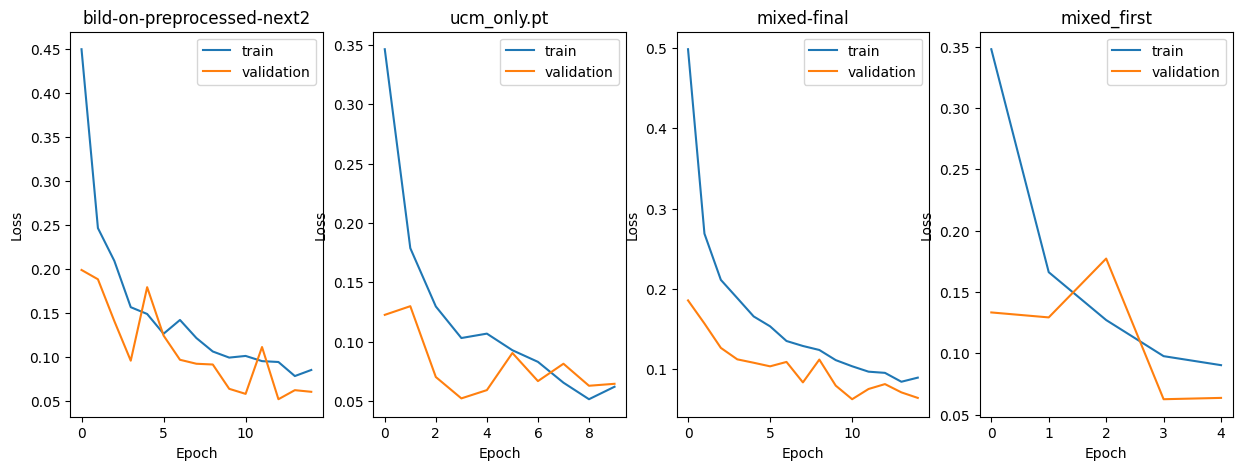

In [10]:
fig, axs = plt.subplots(1, len(histories), figsize=(15, 5))

for i, (model_name, history) in enumerate(histories.items()):
    ax = axs[i]
    ax.set_title(model_name)
    ax.plot(history["train_loss"], label="train")
    ax.plot(history["val_loss"], label="validation")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

plt.show()

In [15]:
datasets = ["mixed", "sg27"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
saved_models = [
    "initial_good.pt", 
    "mixed_first.pt", 
    "bild-on-preprocessed-next2.pt",
    "mixed-final.pt",
]
models = {model_name: pcs.models.PointConvNet().to(device) for model_name in saved_models}
for model_name, model in models.items():
    model.load_state_dict(torch.load(f"./out/checkpoints/{model_name}"))
    model.eval()

In [17]:
import torch.utils
import torch.utils.data
import numpy as np

def calculate_per_class_stats(
    model: torch.nn.Module, dataset: torch.utils.data.DataLoader, n_classes: int
) -> tuple[list[float], list[float]]:
    all_labels = []
    all_predictions = []
    for points, labels in tqdm.tqdm(dataset):
        with torch.no_grad():
            predictions = model(points)
        all_labels.append(labels)
        all_predictions.append(predictions.argmax(dim=1))
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)
    per_class_accuracy = []
    for i in range(n_classes):
        mask = all_labels == i
        correct = (all_predictions[mask] == i).sum().item()
        total = mask.sum().item()
        try:
            per_class_accuracy.append(correct / total)
        except ZeroDivisionError:
            per_class_accuracy.append(-1)
    per_class_iou = []
    for i in range(n_classes):
        mask = all_labels == i
        intersection = (all_predictions[mask] == i).sum().item()
        union = mask.sum().item() + (all_predictions == i).sum().item() - intersection
        try:
            per_class_iou.append(intersection / union)
        except ZeroDivisionError:
            per_class_iou.append(-1)
    return per_class_accuracy, per_class_iou

In [18]:
import pandas as pd

results = []
for model_name, model in models.items():
    for dataset_name in datasets:
        point_trainsforms = []
        if "preprocessed" in model_name or "final" in model_name:
            point_trainsforms.extend([
                pcs.preprocess.normalize_position,
                pcs.preprocess.normalize_colors,
                pcs.preprocess.normalize_intensity,
            ])
        point_trainsforms.append(lambda x: torch.tensor(x.T, dtype=torch.float32))
        dataset = pcs.dataset.SemSegDataset(
            data_dir=f"./data/aggregated/{dataset_name}/test/",
            point_transforms=point_trainsforms,
            label_transforms=(
                lambda x: torch.tensor(x-1, dtype=torch.long),
            ),
            load_device=device,
        )
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
        per_class_accuracy, per_class_iou = calculate_per_class_stats(model, dataloader, 8)
        results.append({
            "model": model_name,
            "dataset": dataset_name,
        })
        for metric, score in zip(["accuracy", "iou"], [per_class_accuracy, per_class_iou]):
            for i in range(8):
                results[-1][f"{metric}_{i}"] = score[i]
pd.DataFrame(results)

  0%|          | 0/84 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


,model,dataset,accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7,iou_0,iou_1,iou_2,iou_3,iou_4,iou_5,iou_6,iou_7
0,initial_good.pt,mixed,0.415028,0.994674,0.992902,0.089527,0.493319,0.311820,0.202520,0.415650,0.411620,0.879084,0.916232,0.079021,0.371149,0.094748,0.177119,0.050521
1,initial_good.pt,sg27,0.006781,1.000000,-1.000000,0.000418,0.478837,0.014121,0.037369,0.323604,0.006779,0.113542,0.000000,0.000251,0.388751,0.001634,0.029976,0.105225
2,mixed_first.pt,mixed,0.994826,0.994672,0.989402,0.971337,0.985140,0.945092,0.356886,0.045654,0.987579,0.990455,0.969264,0.817036,0.967929,0.908622,0.090257,0.042497
3,mixed_first.pt,sg27,0.995120,0.948947,-1.000000,0.929228,0.884912,0.296211,0.423019,0.100508,0.988633,0.948657,0.000000,0.145306,0.749052,0.285477,0.073468,0.088656
4,bild-on-preprocessed-next2.pt,mixed,0.260939,0.982997,0.977669,0.076458,0.753582,0.233219,0.034803,0.392529,0.255199,0.691360,0.805970,0.064160,0.450180,0.134098,0.032805,0.122445
5,bild-on-preprocessed-next2.pt,sg27,0.020242,0.948947,-1.000000,0.000000,0.752076,0.042445,0.000000,0.358593,0.020232,0.746374,0.000000,0.000000,0.389231,0.001463,0.000000,0.170272
6,mixed-final.pt,mixed,0.984888,0.984688,0.990636,0.891751,0.980173,0.955726,0.088059,0.984075,0.966674,0.961466,0.974425,0.816227,0.974371,0.907712,0.086899,0.745455
7,mixed-final.pt,sg27,0.062012,0.948947,-1.000000,0.863883,0.860962,0.286031,0.000000,0.636698,0.061899,0.948128,0.000000,0.738665,0.178792,0.165861,0.000000,0.370423


In [30]:
per_set_class_weights = {}
for src_dataset in ("sg27", "mixed"):
    dataset = pcs.dataset.SemSegDataset(
        data_dir=f"./data/aggregated/{src_dataset}/test/",
        point_transforms=[
            pcs.preprocess.normalize_position,
            pcs.preprocess.normalize_colors,
            pcs.preprocess.normalize_intensity,
            lambda x: torch.tensor(x.T, dtype=torch.float32),
        ],
        label_transforms=(
            lambda x: torch.tensor(x-1, dtype=torch.long),
        ),
        load_device=device,
    )
    class_counts = torch.zeros(8).to(device)
    for points, labels in dataset:
        class_counts += torch.bincount(labels, minlength=8)
    class_weights = class_counts / class_counts.sum()
    per_set_class_weights[src_dataset] = class_weights.cpu().numpy()

In [42]:
acc_summary = pd.DataFrame(results).drop(columns=[f"iou_{i}" for i in range(8)])
acc_summary["OA"] = acc_summary.apply(lambda x: (x[[f"accuracy_{i}" for i in range(8)]].to_numpy() * per_set_class_weights[x['dataset']]).sum(), axis=1)
acc_summary

,model,dataset,accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7,OA
0,initial_good.pt,mixed,0.415028,0.994674,0.992902,0.089527,0.493319,0.311820,0.202520,0.415650,0.549616
1,initial_good.pt,sg27,0.006781,1.000000,-1.000000,0.000418,0.478837,0.014121,0.037369,0.323604,0.172279
2,mixed_first.pt,mixed,0.994826,0.994672,0.989402,0.971337,0.985140,0.945092,0.356886,0.045654,0.976610
3,mixed_first.pt,sg27,0.995120,0.948947,-1.000000,0.929228,0.884912,0.296211,0.423019,0.100508,0.935785
4,bild-on-preprocessed-next2.pt,mixed,0.260939,0.982997,0.977669,0.076458,0.753582,0.233219,0.034803,0.392529,0.582975
5,bild-on-preprocessed-next2.pt,sg27,0.020242,0.948947,-1.000000,0.000000,0.752076,0.042445,0.000000,0.358593,0.227548
6,mixed-final.pt,mixed,0.984888,0.984688,0.990636,0.891751,0.980173,0.955726,0.088059,0.984075,0.977439
7,mixed-final.pt,sg27,0.062012,0.948947,-1.000000,0.863883,0.860962,0.286031,0.000000,0.636698,0.290932


In [43]:
iou_summary = pd.DataFrame(results).drop(columns=[f"accuracy_{i}" for i in range(8)])
iou_summary["mIoU"] = iou_summary.apply(lambda x: (x[[f"iou_{i}" for i in range(8)]].to_numpy() * per_set_class_weights[x['dataset']]).sum(), axis=1)
iou_summary

,model,dataset,iou_0,iou_1,iou_2,iou_3,iou_4,iou_5,iou_6,iou_7,mIoU
0,initial_good.pt,mixed,0.411620,0.879084,0.916232,0.079021,0.371149,0.094748,0.177119,0.050521,0.457645
1,initial_good.pt,sg27,0.006779,0.113542,0.000000,0.000251,0.388751,0.001634,0.029976,0.105225,0.084550
2,mixed_first.pt,mixed,0.987579,0.990455,0.969264,0.817036,0.967929,0.908622,0.090257,0.042497,0.958508
3,mixed_first.pt,sg27,0.988633,0.948657,0.000000,0.145306,0.749052,0.285477,0.073468,0.088656,0.903596
4,bild-on-preprocessed-next2.pt,mixed,0.255199,0.691360,0.805970,0.064160,0.450180,0.134098,0.032805,0.122445,0.409394
5,bild-on-preprocessed-next2.pt,sg27,0.020232,0.746374,0.000000,0.000000,0.389231,0.001463,0.000000,0.170272,0.142848
6,mixed-final.pt,mixed,0.966674,0.961466,0.974425,0.816227,0.974371,0.907712,0.086899,0.745455,0.956848
7,mixed-final.pt,sg27,0.061899,0.948128,0.000000,0.738665,0.178792,0.165861,0.000000,0.370423,0.160870
